# Westeros Tutorial - Implementation of cooling technologies



In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df
from message_ix.reporting import Reporter
from ixmp.reporting import configure

# configure unit 
configure(units={'replace': {'-': ''}})

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform(name = 'local')

In [3]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'cooling_tech_basin', 'illustrating cooling tech using addon',
                  keep_solution=False)
scen.check_out()

In [4]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

## Retrieve parameters to perform subsequent addition of parameters

In [5]:
#year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'
gdp_profile = pd.Series([1., 1.5, 1.9], index=pd.Index([700, 710, 720], name='Time'))

In [6]:
basin = ('basin_1', 'basin_2')

scen.add_spatial_sets({'region': country,
                           'country':basin
                          })

In [7]:
basin = ('basin_1', 'basin_2')

scen.add_spatial_sets({ 'basin':basin
                          })
basin = pd.DataFrame({ "node_parent": ('Westeros','Westeros','basin_1', 'basin_2'),
                       "node": ('basin_1', 'basin_2','basin_1', 'basin_2')})
scen.add_set("map_node",basin)

### Define helper functions

In [8]:
base_input1 = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    'commodity': 'electricity',
    'time': 'year',
    'time_origin': 'year',
}

base_input2 = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    #'commodity': 'electricity',
    'time': 'year',
    'time_origin': 'year',
}


base_output = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_dest': country,
    'time': 'year',
    'time_dest': 'year', 
    'unit': '%',
}


base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '%',
}

base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kW',
}

base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

base_capacity = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'GW',
}

base_activity = {
    'node_loc': country,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

## Defining new levels and commodities
Two new `levels` are added to the model:
1. `water_supply` will be used to model the water flows.
2. `cooling` will be used to model the cooling requirements.

In [9]:
scen.add_set("commodity", ["water_source","water_demand","t_d"])
scen.add_set("level", ["water_supply"])
scen.add_set("technology", ['freshwater', 'groundwater','saline'])
scen.add_set("mode", "standard")

In [10]:
scen.add_set("level", ["water_supply_basin","water_supply_region"])
scen.add_set("commodity", ["freshwater_basin","freshwater_region","salinewater_basin","salinewater_region"])

scen.add_set("level", ["cooling"])
scen.add_set("commodity", ["cooling_req"])

### addon technology - interlinking technologies
In order to demonstrate the use of this feature, we will be adding a new demand for water to this scenario. This demand will be met by the coal_ppl via three cooling technologies, the addon technology.

We will therefore go through the following steps:

#### Cooling technology types
Add new technologies:
1. Once-through cooling by freshwater - `coal_ppl_ot_fresh`
2. Closed loop cooling by freshwater - `coal_ppl_cl_fresh`
3. Once through cooling seawater `coal_ppl_ot_saline`
4. Air cooling `coal_ppl_air`

Link these cooling tehcnologies to the `coal_ppl` using the addon feature.

## Adding freshwater supply & instream extraction as techs

The water supply technologies have only input & output dataframe in model. 

*At some point, we may want to link it to global water supply model in future


In [11]:
scen.set('level')

0              secondary
1                  final
2                 useful
3           water_supply
4     water_supply_basin
5    water_supply_region
6                cooling
dtype: object

In [12]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}


base_input = make_df(base, time_origin='year')
base_output = make_df(base, time_dest='year')

In [13]:
df_in = make_df(base_input, technology='freshwater', commodity='freshwater_basin',  
                  level='water_supply_basin')

basin_value = {'basin_1':75, 'basin_2':45}
for node, val in basin_value.items():
    df_in1 = make_df(df_in,node_loc = node, node_origin=node, value=1)
    scen.add_par('input', df_in1)
    
df_out = make_df(base_output, technology='freshwater', commodity='freshwater_region', 
                   level='water_supply_region')


for node, val in basin_value.items():
    df_out1 = make_df(df_out,node_loc = node , node_dest=country, value=val)
    scen.add_par('output', df_out1)

In [14]:
df_in = make_df(base_input, technology='saline', commodity='salinewater_basin',  
                  level='water_supply_basin')

basin_value = {'basin_1':75, 'basin_2':45}
for node, val in basin_value.items():
    df_in1 = make_df(df_in,node_loc = node, node_origin=node, value=1)
    scen.add_par('input', df_in1)
    
df_out = make_df(base_output, technology='saline', commodity='salinewater_region', 
                   level='water_supply_region')


for node, val in basin_value.items():
    df_out1 = make_df(df_out,node_loc = node , node_dest=country, value=val)
    scen.add_par('output', df_out1)

In [15]:
tecs = {'freshwater': ['water_supply_region', 1.0, 0.0001],
        'saline': ['water_supply_region', 1.0, 0.0001]
       }
      
for tec in tecs:
#     #scen.add_set('technology', tec)
#     df_out = make_df(base_output, technology=tec, commodity=tecs[tec][0], 
#                      level='water_supply', value=tecs[tec][1])

#     scen.add_par('output', df_out)

    df_var = make_df(base_var_cost, technology=tec, value=tecs[tec][2])
    scen.add_par('var_cost', df_var)

In [16]:
# # New Technology used for depicting water sources
# # {tech name: [output commodity, output factor, varaible cost]}
# tecs = {'freshwater': ['water_supply', 1.0, 0.0001],
#         'groundwater': ['water_supply', 1.0, 0.0001]
#        }
      
# for tec in tecs:
#     scen.add_set('technology', tec)
#     df_out = make_df(base_output, technology=tec, commodity=tecs[tec][0], 
#                      level='water_supply', value=tecs[tec][1])

#     scen.add_par('output', df_out)

#     df_var = make_df(base_var_cost, technology=tec, value=tecs[tec][2])
#     scen.add_par('var_cost', df_var)

### Now we add parameters for cooling technologies

We will be using `water required per heat output` for cooling technologies as input value of cooling technology types. 


In [17]:
# {techname: [input commodity, input factor, inv_cost, fix_cost, lifetime]}
tecs = {'coal_ppl_ot_fresh': ['freshwater_region', 0.938, 600., 0., 30.],
        'coal_ppl_cl_fresh': ['freshwater_region', 0.017, 160., 0., 30., 
                              ['secondary', 'electricity', 0.017]],
        'coal_ppl_ot_saline': ['salinewater_region', 0.938, 150., 0., 30],
        'coal_ppl_air': [None, 0.0, 430., 0., 30,
                         ['secondary', 'electricity', 0.102]],
        }

for tec in tecs:
    scen.add_set('technology', tec)

    if tecs[tec][0]:
        df_inp = make_df(base_input2, technology=tec, commodity=tecs[tec][0],  
                         level='water_supply_region', value=tecs[tec][1], unit='-')
        scen.add_par('input', df_inp)

    if tec not in ['coal_ppl_ot_fresh', 'coal_ppl_ot_saline']:
        df_inv = make_df(base_inv_cost, technology=tec, value=tecs[tec][2])
        scen.add_par('inv_cost', df_inv)

    df_fix = make_df(base_fix_cost, technology=tec, value=tecs[tec][3])
    scen.add_par('fix_cost', df_fix)

    df_tl = make_df(base_technical_lifetime, technology=tec, value=tecs[tec][4])
    scen.add_par('technical_lifetime', df_tl)
    
    if len(tecs[tec]) > 5:
        df_inp = make_df(base_input2, technology=tec, commodity=tecs[tec][5][1],  
                         level=tecs[tec][5][0], value=tecs[tec][5][2], unit='-')
        scen.add_par('input', df_inp)

In [18]:
# scen.par('input')

## Addon mapping 
We try to define a single `type_addon` for each power plant. Here we use `coal_ppl` as an example. 

`type_addon` refers to cooling technologies for `coal_ppl` ,whereas `addon` refers to cooling technology types. 

In [19]:
# If we need to add more power plants, we will be using more type_addon here and use the heat rate or cooling requirement per unit of output here
type_addon = 'coal_ppl_cooling'

# Adding cooling technology types 
addon = list(tecs.keys())

scen.add_set('addon', pd.DataFrame({'technology': addon})) 

# Parent technology to map 
parent_tec = 'coal_ppl'

# Mapping addon with type_addon and parent tech
scen.add_cat('addon', type_addon, addon)
scen.add_set('map_tec_addon', pd.DataFrame({'technology': parent_tec,
                                            'type_addon': [type_addon]}))

In this case, we use addon conversion factor for each `type_addon`.Addon conversion factor refers to the heat produced by the parent technology (in this case `coal_ppl`) that is needed to be cooled. 
For now for simplicity, we are referring to heat rate which is 1/efficiency. In the current scenario would be 5. 

In [20]:
df = pd.DataFrame({'node': country,
                   'technology': parent_tec,
                   'year_vtg': vintage_years,
                   'year_act': act_years,
                   'mode': 'standard',
                   'time': 'year',
                   'type_addon': type_addon,
                   'value': 2,
                   'unit': '%'})

scen.add_par('addon_conversion', df)

Now we bound the activity of `cool_coal_ppl` to 100% share of `coal_ppl` to make sure that all of the heat produced is being cooled.

In [21]:
df = pd.DataFrame({'node': country,
                   'technology': parent_tec,
                   'year_act': act_years,
                   'mode': 'standard',
                   'time': 'year',
                   'type_addon': type_addon,
                   'value': 1,
                   'unit': '%'})
scen.add_par('addon_lo', df)

## Commit & Solve 

In [22]:
scen.commit(comment='implement cooling tech')
scen.set_as_default()

In [23]:
scen.solve()

## Using reporting features to see the output of cooling technology. 

The output dataframe here shows the water required per heat rate of `coal_ppl` (as per our understanding)

In [24]:
# Create a reporter from the existing Scenario
rep = Reporter.from_scenario(scen)

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = df['t']
    return df.drop(['t'], axis=1)

/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `plot.bar()`.
  import sys


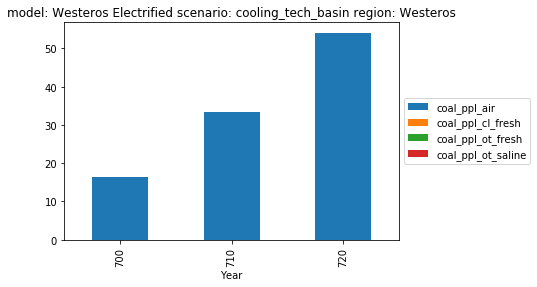

In [25]:
df = rep.full_key('in')
new_key = rep.convert_pyam(
    quantities=df.drop('yv', 'm', 'h', 'ho', 'no', 'c', 'l'),
    year_time_dim='ya',
    collapse=collapse_callback)
water_use = rep.get(new_key[0])
water_use.filter(variable=addon).bar_plot(stacked=True)

In [26]:
#mp.close_db()